### Questions

- How to normalize with the in/decrease of # of papers overall in the dataset. (more/less papers, more/less shares)

- Move away from averages! distributions are highly skewed
    - apply stats after log-transforming?

# Analysis

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2, venn3
import ptitprince as pt 

pd.set_option("display.precision", 2)

In [5]:
sns.set_style("darkgrid")

In [6]:
articles_csv = "../data/plos_ncbi.csv"
metrics_csv = "../data/metrics.csv"
details_csv = "../data/details.csv"

### Load details and metrics

In [340]:
articles = pd.read_csv(articles_csv, index_col="doi", parse_dates=['publication_date'])
articles['year'] = articles.publication_date.map(lambda x: x.year)

details = pd.read_csv(details_csv, index_col="id", parse_dates=['received_at', 'og_updated_time', 'publication_date', 'added_on'])
details['year'] = details.publication_date.map(lambda x: x.year)

metrics = pd.read_csv(metrics_csv, index_col="doi")
metrics.rename(columns={'facebook': 'public_fb',
                        'shares': 'private_fb_api',
                        'diff': 'fb_diff_api',
                        'reactions': 'fb_reactions_api',
                        'comments' : 'fb_comments_api'}, inplace=True)
del metrics['total']

# Only keep non-zero engagement numbers
for _ in ['private_fb', 'fb_comments', 'fb_reactions']:
    metrics[_] = metrics[_+"_api"][metrics[_+"_api"] != 0]
metrics['diff'] = metrics['private_fb'] - metrics['public_fb']

In [341]:
diff_ogids = details.groupby(["doi", "og_id"]).size().groupby(['og_id']).count()
temp = diff_ogids.value_counts()
df = pd.concat([temp, (100*temp/temp.sum()).astype(object)], axis=1)
df.columns = ["og_ids", "%"]
df.index.name = "dois sharing same og_id"
df.sort_index()

,og_ids,%
dois sharing same og_id,,
1,123552,1e+02
2,113,0.091
3,138,0.11
4,5,0.004
5,1,0.00081
33,1,0.00081
754,1,0.00081


In [342]:
bad_ogids = diff_ogids[diff_ogids>1].keys()
a = len(metrics.loc[details[details.og_id.isin(bad_ogids)].doi])
dropped_years = details[details.og_id.isin(bad_ogids)].drop_duplicates(subset="doi").year.value_counts()

metrics = metrics.drop(metrics.loc[details[details.og_id.isin(bad_ogids)].doi].index, axis=0)
details = details.drop(details[details.og_id.isin(bad_ogids)].index, axis=0)

In [343]:
print("Duplicate og_ids: {}".format(len(bad_ogids)))
print("Dropped articles: {} ({:.2f}%)".format(a, 100 * a / articles.shape[0]))
print("Dropped articles | Years:")
dropped_years

Duplicate og_ids: 259
Dropped articles: 1863 (1.59%)
Dropped articles | Years:


2014    489
2013    450
2017      9
2015      9
2016      6
Name: year, dtype: int64

# Basic stats

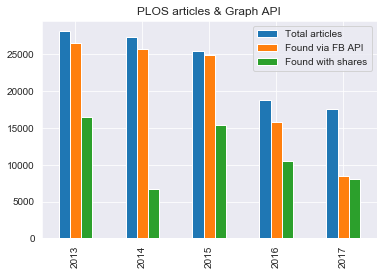

In [344]:
df = pd.DataFrame(columns=['Total articles', 'Found via FB API', 'Found with shares'])

df['Total articles'] = articles.year.value_counts()
df['Found via FB API'] = details[['doi', 'year']].drop_duplicates(subset="doi").year.value_counts()
df['Found with shares'] = details[details.doi.isin(metrics.private_fb.dropna().index)].year.value_counts()
df.plot(kind="bar")
plt.title("PLOS articles & Graph API");

## Coverage

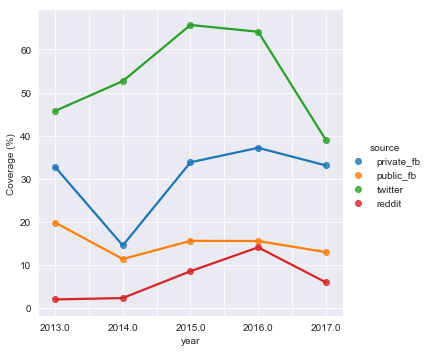

In [346]:
sources = ['private_fb', 'public_fb', 'twitter', 'reddit']
cp = sns.color_palette(n_colors=len(sources))

pdf = pd.DataFrame(columns=["year", "coverage", "source"])
for source in sources:    
    dois = metrics[source].dropna().index
    df = details[details.doi.isin(dois)].drop_duplicates(subset="doi").year.value_counts()
    
    for year, coverage in df.iteritems():
        pdf.loc[len(pdf)+1] = [year, 100 * coverage / year_counts[year], source]

sns.lmplot(x="year", y="coverage", hue="source", data=pdf, lowess=True)

plt.ylabel("Coverage (%)")
for label in plt.gca().xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

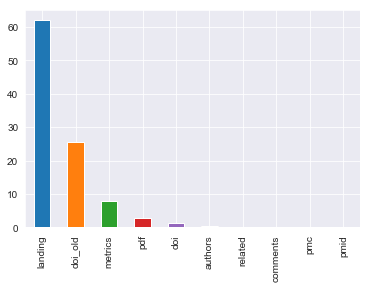

In [347]:
# Link types that were shared once at least
type_count = details.type.value_counts()
types = pd.concat([type_count, (type_count/type_count.sum()*100).astype(object)], axis=1)
types.columns = ["n", "%"]
types['%'].plot(kind="bar");

### Numbers of links that were shared per article

In [80]:
# How many different links were shared per article
diff_links = details.groupby(["doi"])['og_id'].size()
temp = diff_links.value_counts()
df = pd.concat([temp, (temp/temp.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df

,n,%
1,62271,61
2,35321,35
3,3250,3.2
4,382,0.38
5,71,0.07
6,16,0.016
7,8,0.0079
8,5,0.0049


### Open Graph IDs per article

In [361]:
diff_ogids = details.groupby(["doi", "og_id"]).size().groupby(['doi']).count()
temp = diff_ogids.value_counts()
df = pd.concat([temp, (temp/temp.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df

,n,%
1,79546,79
2,21328,21
3,450,0.44


## Comparing public & private distributions

Do the public and private shares follow the same distributions?

By looking at the rank of articles by shares (highest shares -> rank 1, etc) we can compare the nature of the two distributions.

Overall results show that shares follow an exponential distribution in both cases. Scale differende between the two distributions seems to be close to an **order of magnitude**

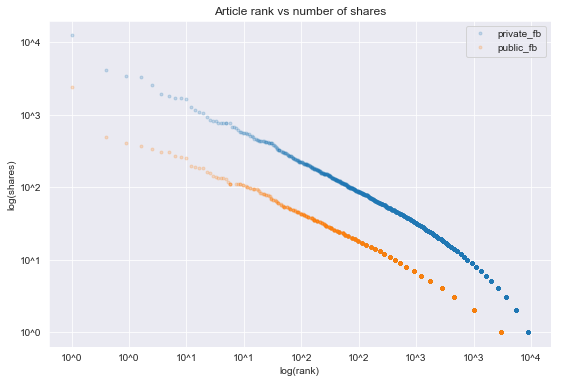

In [358]:
pdf = metrics[['public_fb', 'private_fb']].dropna()
cp = sns.color_palette(n_colors=2)

pdf = pd.concat([pdf, pdf.apply(lambda x: x.rank(ascending=False, method="min"))], axis=1)
pdf.columns = ['public', 'private', 'public_rank', 'private_rank']

pdf = pdf.apply(lambda x: x.map(lambda x: np.log10(x) if pd.notnull(x) else None))
# pdf = pdf.apply(lambda x: x.map(lambda x: x + np.random.normal(0,.03) if pd.notnull(x) else None))

fig, ax = plt.subplots(figsize=(9, 6))

plt.plot(pdf['private_rank'].dropna(), pdf['private'].dropna(), '.', color=cp[0], alpha=.2, label="private_fb")
plt.plot(pdf['public_rank'].dropna(), pdf['public'].dropna(), '.', color=cp[1], alpha=.2, label="public_fb")

plt.title("Article rank vs number of shares")
 
labels = ["10^{}".format(int(item)) for item in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)

labels = ["10^{}".format(int(item)) for item in ax.get_yticks().tolist()]
ax.set_yticklabels(labels)

plt.xlabel("log(rank)")
plt.ylabel("log(shares)")

plt.legend();

The same exercise can be repeated for each individual year.

The emerging picture is a bit more complex...

While distributions individually seem to roughly follow exponential growth, the relationship between the distribtions varies over the years. Especially 2014 is standing out, eventually accountable to the amount of data dropped due to data removed previously based on wrongly merged articles by og_ids.

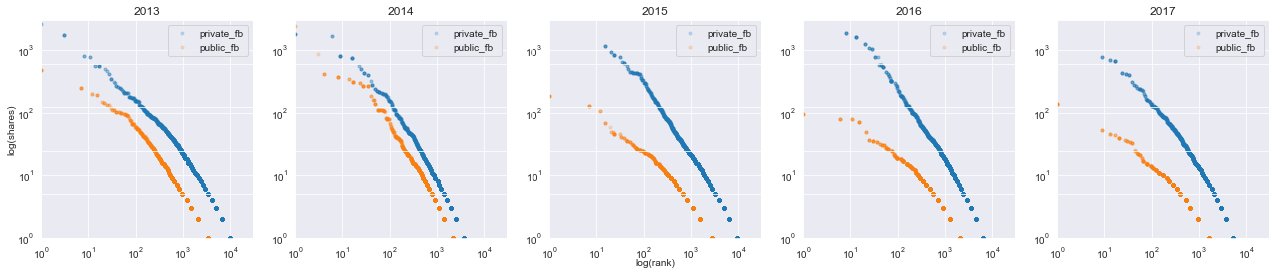

In [204]:
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
cp = sns.color_palette(n_colors=2)
for ax, sel_year in zip(axes, range(2013, 2018)):
    ax.set_title(sel_year)
    pdf = metrics.reindex(details[details.year == sel_year].doi)
    pdf = pdf[['public_fb', 'private_fb']]
    pdf = pd.concat([pdf, pdf.apply(lambda x: x.rank(ascending=False, method="min"))], axis=1)
    pdf.columns = ['public', 'private', 'public_rank', 'private_rank']
    
    ax.plot(pdf['private_rank'].dropna(), pdf['private'].dropna(), '.', color=cp[0], alpha=.2, label="private_fb")
    ax.plot(pdf['public_rank'].dropna(), pdf['public'].dropna(), '.', color=cp[1], alpha=.2, label="public_fb")
    
    ax.set_xlim(1, 30000)
    ax.set_ylim(1, 3000)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel("log(rank)")
plt.ylabel("log(shares)");

## Raindrop plots

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


(-0.1, 4)

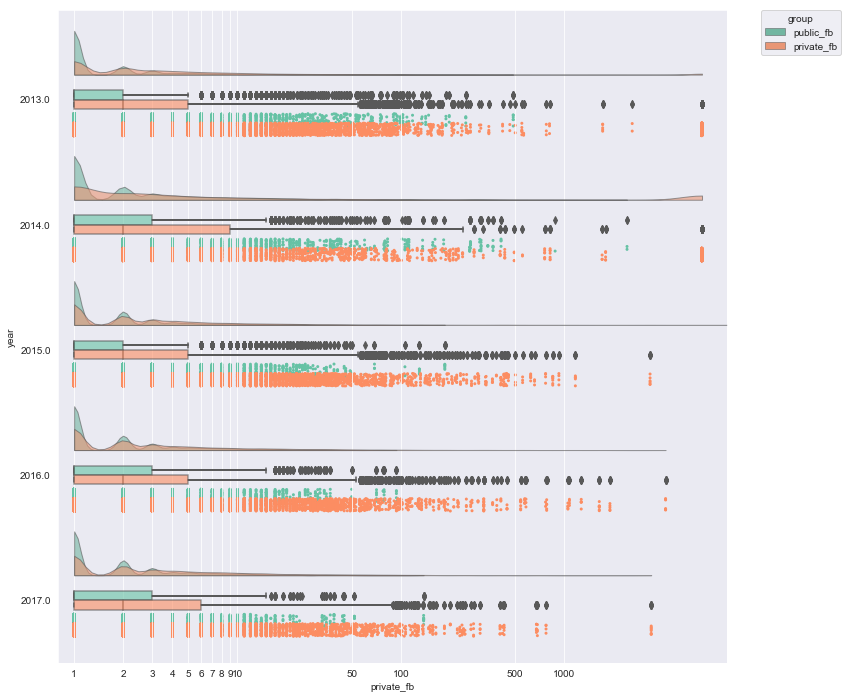

In [154]:
pdf = metrics.merge(details[['doi', 'year']], left_index=True, right_on="doi", how="left")
pdf = pdf.melt(value_vars=["public_fb", "private_fb"], id_vars="year", var_name="group", value_name="private_fb").dropna()
# pdf = pdf.sample(21000)
pdf['private_fb'] = np.log10(pdf['private_fb'])

# Plot the repeated measures data
dx = "year"; dy = "private_fb"; dhue = "group"; ort = "h"; pal = "Set2"; sigma = .1

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = pdf, palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,12), orient = ort , alpha = .6, dodge = True, pointplot = False, move = .2)

ticks = list(range(11)) + [50, 100, 500, 1000]
plt.xticks(np.log10(ticks), ticks)
plt.xlim(-0.1,4)

## Most shared link types for articles with up to 2 shared links

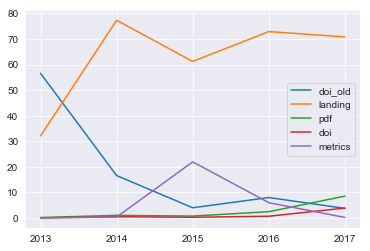

In [153]:
df = pd.DataFrame()
for sel_year in range(2013, 2018):
    pdf = details.loc[details[details.year == sel_year].index]
    diff_links = pdf.groupby(["doi"])['og_id'].size()
    df[sel_year] = 100 * pdf[pdf.doi.isin(diff_links[diff_links <= 2].index)].type.value_counts() / len(pdf)
    # df[sel_year] = pdf[pdf.doi.isin(diff_links[diff_links <= 2].index)].type.value_counts()
df.columns = pd.to_datetime(df.columns, format="%Y")
df.T.plot()

The old DOI (http://dx.doi.org/[doi]) is slowly not being used anymore. Simultaneously the shares of landing pages has increased.

There was a surge in the number of shared links to the metrics page of articles.

- Is the increased ratio of shared links to landing pages due to a change in infrastructure (share buttons, CrossRef switching to the new DOI) or an indicator of different sharing behaviour?
- Is that that behaviour because of a change of behaviour in the population of scientists or due to the introduction of a another, differntly behaving population (non-scientists who are not familiar with the sharing of DOIs)?

## Coverage

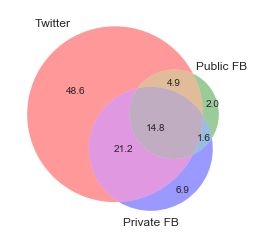

In [296]:
pdf = metrics

public_set = set(pdf['public_fb'].dropna().index.tolist())
private_set = set(pdf['private_fb'].dropna().index.tolist())
twitter_set = set(pdf['twitter'].dropna().index.tolist())

total = len(am_set.union(twitter_set).union(api_set))

venn3([twitter_set, public_set, private_set], set_labels=('Twitter', 'Public FB', 'Private FB'),
      subset_label_formatter=lambda x: "{:.1f}".format(100*x/total));

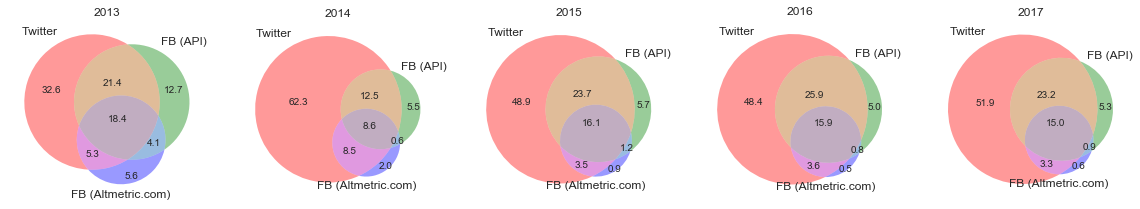

In [292]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))


for sel_year, ax in zip(range(2013, 2018), axes):
    ax.set_title(sel_year)
    dois = articles[articles.year == sel_year].index
    pdf = metrics.reindex(dois)

    am_set = set(pdf['public_fb'].dropna().index.tolist())
    twitter_set = set(pdf['twitter'].dropna().index.tolist())
    api_set = set(pdf['private_fb'].dropna().index.tolist())
    
    total = len(am_set.union(twitter_set).union(api_set))

    venn3([twitter_set, api_set, am_set], 
          set_labels=('Twitter', 'FB (API)', 'FB (Altmetric.com)'),
          ax=ax, subset_label_formatter=lambda x: "{:.1f}".format(100*x/total));

In [298]:
am_set = set(metrics['public_fb'].dropna().index.tolist())
fb_set = set(metrics['private_fb'].dropna().index.tolist())

any_set = am_set.union(fb_set)
both_set = am_set.intersection(fb_set)

len(any_set), len(both_set)

(40943, 13055)

In [301]:
metrics.reindex(any_set)[['public_fb', 'private_fb']].fillna(0).corr(method="spearman")

,public_fb,private_fb
public_fb,1.00,0.08
private_fb,0.08,1.00


In [302]:
metrics.reindex(both_set)[['public_fb', 'private_fb']].corr(method="spearman")

,public_fb,private_fb
public_fb,1.00,0.52
private_fb,0.52,1.00


(0, 30)

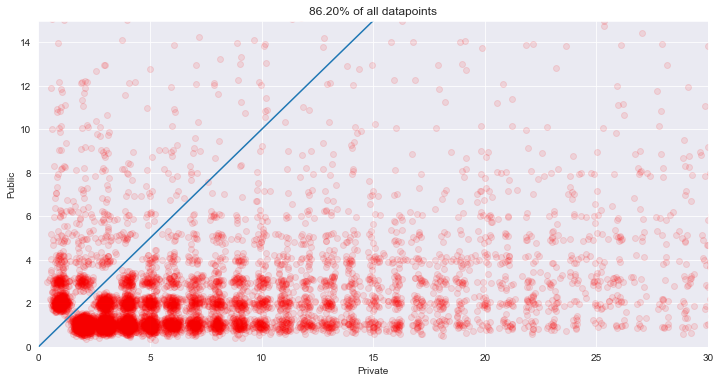

In [308]:
x, y = (30, 15)
h = 6
plt.figure(figsize=(h*(x/y),h))

pdf = metrics[['public_fb', 'private_fb']].dropna()
# pdf = pdf.sample(100)
pdf = pdf[pdf.private_fb != pdf.public_fb]

# add noice to jitter scatterplot
v, w = pdf['private_fb'], pdf['public_fb']
v,w = v + np.random.normal(0,.2,len(pdf)), w + np.random.normal(0,.2,len(pdf))

# sns.kdeplot(pdf['shares>0'], pdf['facebook'], clip=(0,200), cmap='magma_r', alpha=.7)
plt.scatter(v, w, marker='o', color='r', alpha=0.1)
# diagonal
plt.plot(range(0,1000))


s = pdf[(pdf['private_fb']<=x) & (pdf['public_fb']<=y)]
plt.title("{:.2f}% of all datapoints".format(100*len(s)/len(pdf)))
plt.ylabel('Public')
plt.xlabel('Private')

plt.ylim(0,y)
plt.xlim(0,x)

(0, 4)

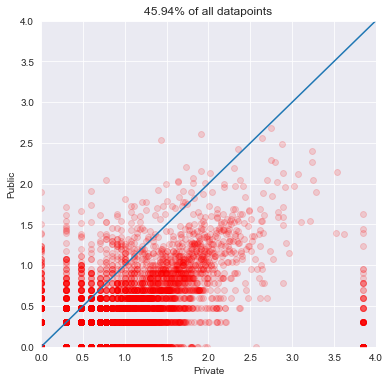

In [318]:
x, y = (4, 4)
h = 6
plt.figure(figsize=(h*(x/y),h))

pdf = metrics[['public_fb', 'private_fb']].dropna()
total = len(pdf)

pdf = pdf.sample(frac=.8)

# add noice to jitter scatterplot
v, w = pdf['private_fb'], pdf['public_fb']
# v,w = v + np.random.normal(0,.2,len(pdf)), w + np.random.normal(0,.2,len(pdf))
v,w = np.log10(v), np.log10(w)

# sns.kdeplot(pdf['shares>0'], pdf['facebook'], clip=(0,200), cmap='magma_r', alpha=.7)
plt.scatter(v, w, marker='o', color='r', alpha=0.15)
# diagonal
plt.plot(range(0,1000))

s = pdf[(pdf['private_fb']<=x) & (pdf['public_fb']<=y)]

plt.title("{:.2f}% of all datapoints".format(100*len(s)/total))

plt.ylabel('Public')
plt.xlabel('Private')

plt.ylim(0,y)
plt.xlim(0,x)

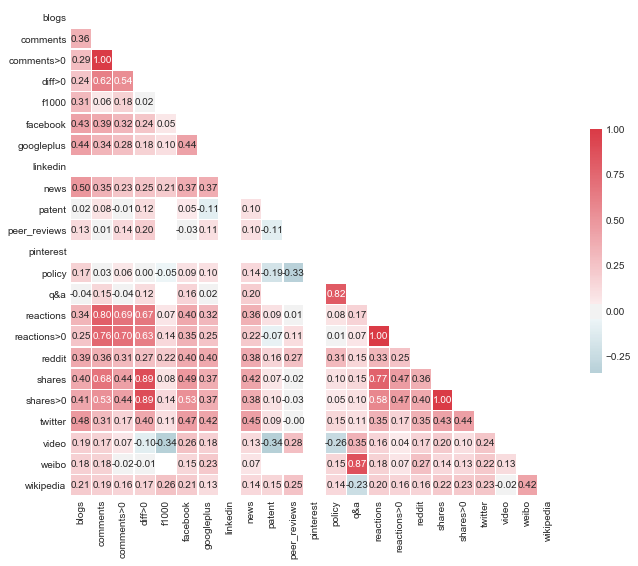

In [15]:
# Compute the correlation matrix
corr = metrics[metrics.columns.difference(['total', 'diff'])].corr(method="spearman")

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

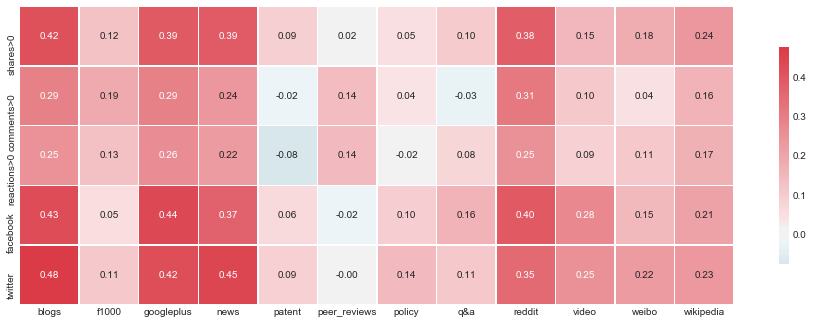

In [197]:
# Compute the correlation matrix
rel_metrics = [_+">0" for _ in fb_metrics] + ['facebook', 'twitter']
drop_metrics = fb_metrics + ['total', 'diff', 'diff>0', 'linkedin', 'pinterest']
corr = metrics[metrics.columns.difference(drop_metrics)].dropna().corr(method="spearman")
corr = corr.loc[rel_metrics, corr.columns.difference(rel_metrics)]
# corr = corr.sort_index()

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 8))
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

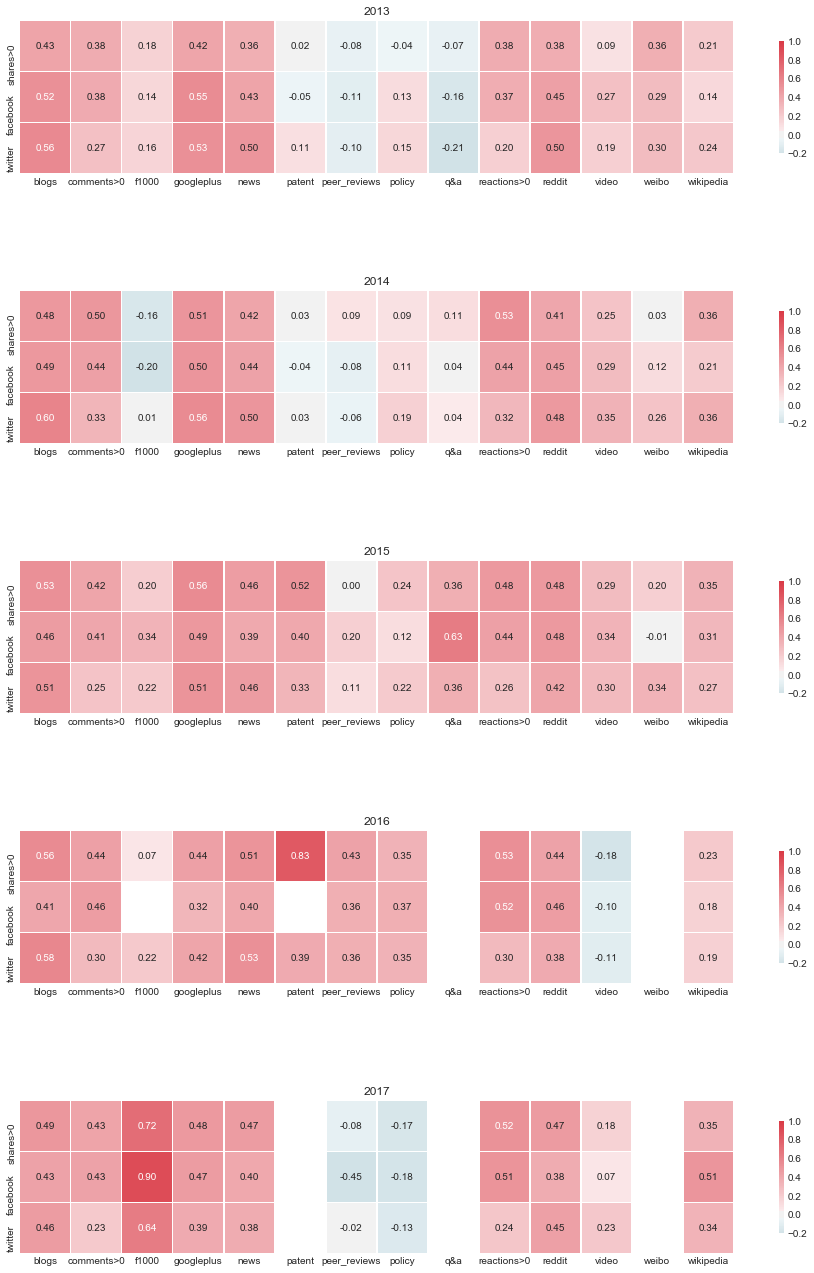

In [212]:
rel_metrics = [_+">0" for _ in ['shares']] + ['facebook', 'twitter']
drop_metrics = fb_metrics + ['total', 'diff', 'diff>0', 'linkedin', 'pinterest']

cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    f, axes = plt.subplots(5, 1, figsize=(16, 24))
    for ax, sel_year in zip(axes, range(2013, 2018)):
        ax.set_title(sel_year)
        tdf = metrics.reindex(details[details.year == sel_year].doi)
        corr = tdf[tdf.columns.difference(drop_metrics)].corr(method="spearman")
        corr = corr.loc[rel_metrics, corr.columns.difference(rel_metrics)]
        # corr = corr.sort_index()

        sns.heatmap(corr, cmap=cmap, center=0, annot=True, fmt=".2f", vmax=1, vmin=-.2,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

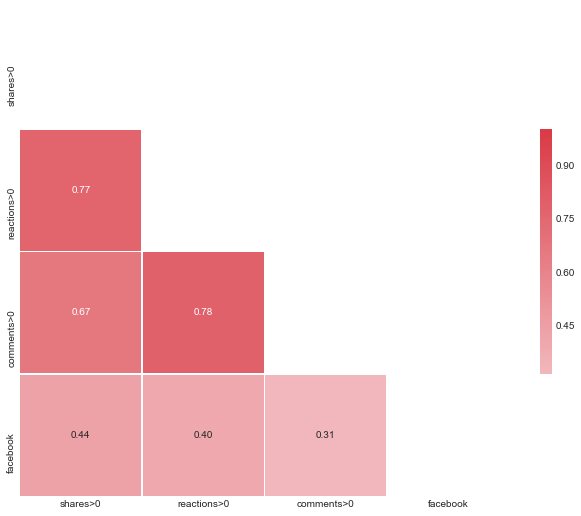

In [199]:
# Compute the correlation matrix

corr = metrics[['shares>0', 'reactions>0', 'comments>0', 'facebook']].fillna(0).corr(method="spearman")

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [218]:
(metrics['diff>0']>0).sum(), (metrics['diff>0']==0).sum(), (metrics['diff>0']<0).sum()

(8415, 3307, 1160)

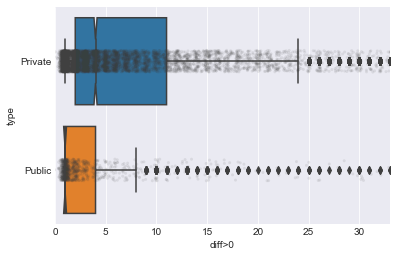

In [221]:
pdf = metrics[metrics['diff>0'] != 0][['diff>0']].copy()
pdf['type'] = pdf['diff>0'].map(lambda x: "Private" if x > 0 else "Public")
pdf['diff>0'] = pdf['diff>0'].abs()
sns.boxplot(x="diff>0", y="type", data=pdf, notch=True)
pdf['diff>0'] = pdf['diff>0'] + np.random.normal(0,.25,len(pdf))
sns.stripplot(x="diff>0", y="type", data=pdf, jitter=True, color=".25", alpha=.1, size=3)
plt.xlim(0, 33);

(-15, 20)

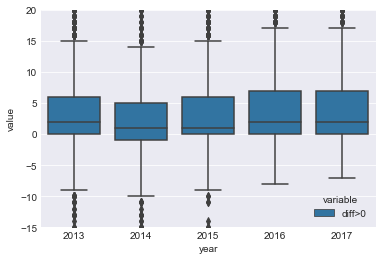

In [228]:
#ax = sns.distplot(diff, hist=False, norm_hist=True);
pdf = metrics.merge(articles[['year']], left_index=True, right_index=True, how="left").melt("year", ["diff>0"])
# sns.stripplot(x="year", y="value", hue="variable", data=pdf, size=2.5, dodge=True, jitter=True, alpha=.15)
sns.boxplot(x="year", y="value", hue="variable", data=pdf)
plt.ylim(-15, 20)

(-50, 100)

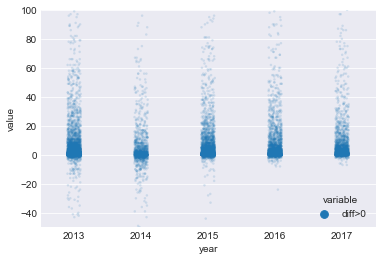

In [223]:
#ax = sns.distplot(diff, hist=False, norm_hist=True);
pdf = metrics.merge(articles[['year']], left_index=True, right_index=True, how="left").melt("year", ["diff>0"])
sns.stripplot(x="year", y="value", hue="variable", data=pdf, size=2.5, dodge=True, jitter=True, alpha=.15)
#sns.boxplot(x="year", y="value", hue="variable", data=pdf)
plt.ylim(-50, 100)

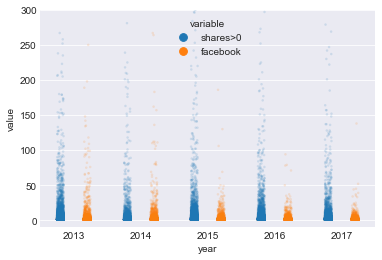

In [165]:
#ax = sns.distplot(diff, hist=False, norm_hist=True);
pdf = metrics.merge(articles[['year']], left_index=True, right_index=True, how="left").melt("year", ["shares>0", "facebook"])
ax = sns.stripplot(x="year", y="value", hue="variable", data=pdf, marker=".", dodge=True, jitter=True, alpha=.15)
plt.ylim(-10,300);

## Others

## Publication date & latest date of sharing

In [79]:
details['pub_to_latest_share'] = (details.og_updated_time - details.publication_date)
details['pub_to_latest_share'] = details['pub_to_latest_share'].map(lambda x: x.days)

# merge with metrics
# tdf = metrics.merge(details[['pub_to_latest_share', 'doi']], left_index=True, right_on="doi", how="left")

details.pub_to_latest_share.describe()

count    144591.00
mean        412.34
std         397.14
min         -20.00
25%          85.00
50%         322.00
75%         587.00
max        2015.00
Name: pub_to_latest_share, dtype: float64

In [34]:
a = details.reset_index().groupby(["type", "og_id"])[['shares']].first().groupby(["type"]).mean()
a['median'] = details.reset_index().groupby(["type", "og_id"])['shares'].first().groupby(["type"]).median()
a['n'] = details.reset_index().groupby(["type", "og_id"]).first().groupby(["type"]).size()
a.rename(columns = {'shares':'mean'})

,mean,median,n
type,,,
authors,81.85,3,533
comments,241.59,2,181
doi,37.76,2,1921
doi_old,5.12,0,37141
landing,2.26,0,89855
metrics,5.82,0,11524
pdf,0.47,0,3987
pmc,1.62,0,66
pmid,0.61,0,64
